In [ ]:
# VERIRAG: Verification-Enhanced RAG - A Self-Disagreement-Aware Retrieval-Augmented Generation (SDAR) System

# Installation and Setup

import os
import json
import warnings
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict, Counter
from llama_index.core import (
    VectorStoreIndex, SimpleDirectoryReader,
    Settings, Document)
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
# Configuration and Global Settings

@dataclass
class SDARConfig:
    corpus_path: str = "./documents"    
    fast_llm_model: str = "llama3:latest"  
    reasoning_llm_model: str = "phi3:mini" 
    embedding_model: str = "BAAI/bge-small-en-v1.5"    
    top_k: int = 10
    chunk_size: int = 512
    chunk_overlap: int = 50    
    entailment_threshold: float = 0.7
    contradiction_threshold: float = 0.3
    min_claim_length: int = 10    
    request_timeout: float = 60.0  
    max_retries: int = 2    
    fig_size: Tuple[int, int] = (12, 8)
config = SDARConfig()
fast_llm = Ollama(
    model=config.fast_llm_model, 
    request_timeout=config.request_timeout,
    additional_kwargs={"num_predict": 512})
reasoning_llm = Ollama(
    model=config.reasoning_llm_model, 
    request_timeout=120.0, 
    additional_kwargs={"num_predict": 1024})
embed_model = HuggingFaceEmbedding(model_name=config.embedding_model)
Settings.llm = fast_llm
Settings.embed_model = embed_model
Settings.chunk_size = config.chunk_size
Settings.chunk_overlap = config.chunk_overlap

In [3]:
# Document Ingestion and Indexing

class DocumentCorpus:
    def __init__(self, corpus_path: str):
        self.corpus_path = Path(corpus_path)
        self.documents = []
        self.index = None
        self.supported_formats = ['.pdf', '.txt', '.docx', '.pptx', '.md', '.csv']
    def load_documents(self) -> List[Document]:
        if not self.corpus_path.exists():
            print(f"Creating corpus directory: {self.corpus_path}")
            self.corpus_path.mkdir(parents=True, exist_ok=True)
            print(f"  Please add documents to {self.corpus_path} and reload")
            print(f"  Supported formats: {', '.join(self.supported_formats)}")
            return []        
        files = list(self.corpus_path.glob('*'))
        supported_files = [f for f in files if f.suffix.lower() in self.supported_formats]
        if not supported_files:
            print(f"No supported documents found in {self.corpus_path}")
            print(f"  Supported formats: {', '.join(self.supported_formats)}")
            return []
        print(f"Found {len(supported_files)} supported files:")
        for f in supported_files:
            print(f"   - {f.name} ({f.suffix})")        
        reader = SimpleDirectoryReader(
            str(self.corpus_path),
            required_exts=self.supported_formats,
            recursive=True)
        try:
            self.documents = reader.load_data()
            print(f"\nSuccessfully loaded {len(self.documents)} document chunks")            
            doc_types = {}
            for doc in self.documents:
                file_name = doc.metadata.get('file_name', 'unknown')
                ext = Path(file_name).suffix.lower()
                doc_types[ext] = doc_types.get(ext, 0) + 1
            print(f"Document breakdown:")
            for ext, count in sorted(doc_types.items()):
                print(f"   {ext}: {count} chunks")
        except Exception as e:
            print(f"Error loading documents: {e}")
            self.documents = []
        return self.documents
    def create_index(self) -> VectorStoreIndex:
        if not self.documents:
            print("No documents loaded. Loading now...")
            self.load_documents()
        if not self.documents:
            print("No documents available for indexing")
            return None
        self.index = VectorStoreIndex.from_documents(self.documents)
        print(f"Vector index created")
        return self.index
    def get_retriever(self, top_k: int):
        if self.index is None:
            self.create_index()
        return self.index.as_retriever(similarity_top_k=top_k)
corpus = DocumentCorpus(config.corpus_path)
corpus.load_documents()
corpus.create_index()

Found 66 supported files:
   - PPT PDF_CCC704 PART-II_INTRO ENVIRON STUDIES JKS 2020 August.pdf (.pdf)
   - PPT PDF_CCC704_PART-I_INTRO ENVIRON STUDIES JKS 2020 August.pdf (.pdf)
   - lecture7-vectorspace.pdf (.pdf)
   - C_Slide_5.pdf (.pdf)
   - IEEE802_15_4e TSCH(Hannes Ch4).pdf (.pdf)
   - Are all cancers death sentences.pdf (.pdf)
   - C_Slide.pptx (.pptx)
   - Lab System calls.pdf (.pdf)
   - IEEE802_15_4_PHY(Hannes Ch4).pdf (.pdf)
   - 05_lecture_FilterLock_BakeryLock.pdf (.pdf)
   - Lecture 11_MO23_Verilog.pdf (.pdf)
   - Intro_IoT_Access_Technologies(Hannes Ch4).pdf (.pdf)
   - Lecture 8_MO23_Verilog.pdf (.pdf)
   - Lecture 9_MO23.pdf (.pdf)
   - class5 neual nerve.pdf (.pdf)
   - networks-book-ch08.pdf (.pdf)
   - 06_lecture_Linearizability.pdf (.pdf)
   - IoT_Ecosystem_(RamgirCh2).pdf (.pdf)
   - macro-ch03.pptx (.pptx)
   - Ecosystem-Part I.pdf (.pdf)
   - Intro_Arduino_Programming.pdf (.pdf)
   - 06score.pdf (.pdf)
   - Lecture1MO2023.pdf (.pdf)
   - 01_lecture_CourseConent

2025-12-22 04:36:16,620 - WARNING - Ignoring wrong pointing object 56 0 (offset 0)
2025-12-22 04:36:17,346 - WARNING - Ignoring wrong pointing object 364 0 (offset 0)
2025-12-22 04:36:17,346 - WARNING - Ignoring wrong pointing object 384 0 (offset 0)



Successfully loaded 2425 document chunks
Document breakdown:
   .pdf: 2278 chunks
   .pptx: 147 chunks
Vector index created


In [4]:
# Atomic Claim Extraction

class ClaimExtractor:    
    def __init__(self, llm):
        self.llm = llm
    def extract_claims(self, text: str, max_retries: int = 2) -> List[str]:
        prompt = f"""Extract key factual claims from this text. Each claim must be:
- One independent fact
- At least {config.min_claim_length} words
- Specific and clear

Text: {text[:1000]}

Return JSON array: ["claim1", "claim2"]
No explanation."""
        for attempt in range(max_retries):
            try:
                response = self.llm.complete(prompt)
                response_text = str(response).strip()                
                if '[' in response_text and ']' in response_text:
                    start = response_text.index('[')
                    end = response_text.rindex(']') + 1
                    json_str = response_text[start:end]
                    claims = json.loads(json_str)                    
                    claims = [c for c in claims if len(c.split()) >= config.min_claim_length]
                    return claims                
                lines = response_text.split('\n')
                claims = []
                for line in lines:
                    line = line.strip().strip('"').strip("'").strip('-').strip()
                    if len(line.split()) >= config.min_claim_length and not line.startswith('['):
                        claims.append(line)
                if claims:
                    return claims[:5]
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"  Retry {attempt + 1}/{max_retries}...")
                    continue
                else:
                    print(f"  Claim extraction failed after {max_retries} attempts")
                    return []
        return []
claim_extractor = ClaimExtractor(fast_llm) 
test_text = """Cancer grading is a system that describes how abnormal cancer cells look under a microscope. 
Grade 1 tumors have cells that look similar to normal cells. Grade 3 tumors have cells that look very different."""
print("\nClaim Extraction Test -")
print("Using fast model for extraction...")
test_claims = claim_extractor.extract_claims(test_text)
for i, claim in enumerate(test_claims, 1):
    print(f"{i}. {claim}")

2025-12-22 04:36:55,525 - INFO - HTTP Request: POST http://localhost:11434/api/show "HTTP/1.1 200 OK"



Claim Extraction Test -
Using fast model for extraction...


2025-12-22 04:37:04,988 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


  Retry 1/2...


2025-12-22 04:37:06,814 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


1. Grade 1 tumors have cells that look similar to normal cells.


In [5]:
# Claim Relationship Analysis

class ClaimRelationshipAnalyzer:    
    def __init__(self, llm):
        self.llm = llm
    def analyze_relationship(self, claim1: str, claim2: str, max_retries: int = 2) -> Dict[str, float]:
        prompt = f"""Compare these claims:
A: {claim1}
B: {claim2}

Return JSON: {{"entailment": 0.0-1.0, "contradiction": 0.0-1.0, "neutral": 0.0-1.0}}
Values sum to 1.0. No explanation."""
        for attempt in range(max_retries):
            try:
                response = self.llm.complete(prompt)
                response_text = str(response).strip()                
                if '{' in response_text and '}' in response_text:
                    start = response_text.index('{')
                    end = response_text.rindex('}') + 1
                    json_str = response_text[start:end]
                    scores = json.loads(json_str)                    
                    total = sum(scores.values())
                    if total > 0:
                        scores = {k: v/total for k, v in scores.items()}
                    return scores
            except Exception as e:
                if attempt < max_retries - 1:
                    continue                
            return {"entailment": 0.0, "contradiction": 0.0, "neutral": 1.0}
        return {"entailment": 0.0, "contradiction": 0.0, "neutral": 1.0}
relationship_analyzer = ClaimRelationshipAnalyzer(fast_llm) 
print("\nRelationship Analysis Test -")
c1 = "Global temperatures have increased significantly in recent decades"
c2 = "Climate change is not happening according to recent data"
rel = relationship_analyzer.analyze_relationship(c1, c2)
print(f"Claim 1: {c1}")
print(f"Claim 2: {c2}")
print(f"Relationship: {rel}")


Relationship Analysis Test -


2025-12-22 04:37:19,592 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


Claim 1: Global temperatures have increased significantly in recent decades
Claim 2: Climate change is not happening according to recent data
Relationship: {'entailment': 0.8, 'contradiction': 0.2, 'neutral': 0.0}


In [6]:
# Disagreement Graph Construction

@dataclass
class ClaimNode:
    id: int
    text: str
    source_doc: str
    chunk_id: int
class DisagreementGraph:    
    def __init__(self):
        self.graph = nx.DiGraph()
        self.claims: List[ClaimNode] = []
        self.relationships: List[Dict] = []
    def add_claims(self, claims: List[str], source_doc: str, chunk_id: int):
        start_id = len(self.claims)
        for i, claim_text in enumerate(claims):
            node = ClaimNode(
                id=start_id + i, text=claim_text, 
                source_doc=source_doc, chunk_id=chunk_id)
            self.claims.append(node)
            self.graph.add_node(node.id, **asdict(node))
    def add_relationship(self, claim_id1: int, claim_id2: int, 
                        relationship: Dict[str, float]):
        self.relationships.append({
            'source': claim_id1,
            'target': claim_id2,
            'entailment': relationship['entailment'],
            'contradiction': relationship['contradiction'],
            'neutral': relationship['neutral']})        
        if relationship['entailment'] > config.entailment_threshold:
            self.graph.add_edge(claim_id1, claim_id2, 
                              type='support', weight=relationship['entailment'])
        elif relationship['contradiction'] > config.contradiction_threshold:
            self.graph.add_edge(claim_id1, claim_id2, 
                              type='contradict', weight=relationship['contradiction'])
    def compute_disagreement_metrics(self) -> Dict[str, float]:
        if len(self.claims) == 0:
            return {}        
        support_edges = sum(1 for _, _, d in self.graph.edges(data=True) 
                          if d.get('type') == 'support')
        conflict_edges = sum(1 for _, _, d in self.graph.edges(data=True) 
                           if d.get('type') == 'contradict')
        total_edges = self.graph.number_of_edges()        
        max_edges = len(self.claims) * (len(self.claims) - 1)
        disagreement_density = conflict_edges / max_edges if max_edges > 0 else 0        
        if total_edges > 0:
            p_support = support_edges / total_edges
            p_conflict = conflict_edges / total_edges
            entropy = 0
            if p_support > 0:
                entropy -= p_support * np.log2(p_support)
            if p_conflict > 0:
                entropy -= p_conflict * np.log2(p_conflict)
        else:
            entropy = 0
        return {
            'disagreement_density': disagreement_density,
            'support_edges': support_edges,
            'conflict_edges': conflict_edges,
            'total_claims': len(self.claims),
            'confidence_entropy': entropy,
            'conflict_ratio': conflict_edges / total_edges if total_edges > 0 else 0}
    def visualize(self, figsize=(14, 10)):
        if len(self.claims) == 0:
            print("No claims to visualize")
            return
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)        
        pos = nx.spring_layout(self.graph, k=2, iterations=50)        
        nx.draw_networkx_nodes(self.graph, pos, node_color='lightblue', 
                              node_size=500, ax=ax1)        
        support_edges = [(u, v) for u, v, d in self.graph.edges(data=True) 
                        if d.get('type') == 'support']
        nx.draw_networkx_edges(self.graph, pos, support_edges, 
                              edge_color='green', width=2, ax=ax1, alpha=0.6,
                              arrows=True, arrowsize=20)        
        conflict_edges = [(u, v) for u, v, d in self.graph.edges(data=True) 
                         if d.get('type') == 'contradict']
        nx.draw_networkx_edges(self.graph, pos, conflict_edges, 
                              edge_color='red', width=2, ax=ax1, alpha=0.6,
                              arrows=True, arrowsize=20, style='dashed')        
        nx.draw_networkx_labels(self.graph, pos, ax=ax1, font_size=8)
        ax1.set_title("Claim Disagreement Graph\n(Green=Support, Red=Conflict)", 
                     fontsize=12, fontweight='bold')
        ax1.axis('off')        
        metrics = self.compute_disagreement_metrics()
        metric_names = list(metrics.keys())
        metric_values = list(metrics.values())
        ax2.barh(metric_names, metric_values, color='steelblue')
        ax2.set_xlabel('Value', fontsize=10)
        ax2.set_title('Disagreement Metrics', fontsize=12, fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        return metrics

In [7]:
# Multi-View Answer Synthesis

class MultiViewSynthesizer:    
    def __init__(self, llm):
        self.llm = llm
    def synthesize_answer(self, query: str, claims: List[ClaimNode], 
                         metrics: Dict[str, float], 
                         relationships: List[Dict]) -> Dict[str, any]:        
        claims_text = "\n".join([f"{i+1}. {c.text}" for i, c in enumerate(claims[:10])])          
        conflict_pct = int(metrics.get('conflict_ratio', 0) * 100)
        prompt = f"""Question: {query}

Evidence from documents:
{claims_text}

{conflict_pct}% of evidence shows disagreement.

Provide a clear answer. If sources conflict, mention both views."""
        try:
            print("  Generating synthesis...")
            response = self.llm.complete(prompt)
            response_text = str(response).strip()            
            result = {
                "dominant_view": response_text[:300] if len(response_text) > 300 else response_text,
                "alternative_views": [],
                "confidence": "medium",
                "uncertainty_note": f"{conflict_pct}% disagreement in sources",
                "synthesis": response_text}            
            if conflict_pct < 10:
                result['confidence'] = 'high'
            elif conflict_pct > 30:
                result['confidence'] = 'low'
            return result
        except Exception as e:
            print(f"  Synthesis error: {e}")
            conflict_pct = int(metrics.get('conflict_ratio', 0) * 100)
            fallback_answer = f"Based on {len(claims)} claims from your documents. "
            if conflict_pct == 0:
                fallback_answer += "All sources agree on this topic."
            elif conflict_pct < 20:
                fallback_answer += f"Sources mostly agree ({100-conflict_pct}% agreement)."
            else:
                fallback_answer += f"Sources show significant disagreement ({conflict_pct}% conflict)."
            return {
                "dominant_view": fallback_answer,
                "alternative_views": [],
                "confidence": "low" if conflict_pct > 30 else "medium",
                "uncertainty_note": f"Synthesis failed: {str(e)[:100]}. {conflict_pct}% conflict detected.",
                "synthesis": f"{fallback_answer} Review the claims manually for details."}
synthesizer = MultiViewSynthesizer(reasoning_llm) 

In [8]:
# End-to-End Pipeline

class SDARPipeline:    
    def __init__(self, corpus: DocumentCorpus, config: SDARConfig):
        self.corpus = corpus
        self.config = config
        self.claim_extractor = ClaimExtractor(fast_llm)  
        self.relationship_analyzer = ClaimRelationshipAnalyzer(fast_llm)  
        self.synthesizer = MultiViewSynthesizer(reasoning_llm) 
        self.results_history = []
    def query(self, query_text: str, visualize: bool = True, max_chunks: int = 5) -> Dict:
        print("\n")
        print(f"Query: {query_text}")
        print("\n")        
        print("Step 1: Retrieving relevant documents...")
        retriever = self.corpus.get_retriever(self.config.top_k)
        retrieved_nodes = retriever.retrieve(query_text)        
        retrieved_nodes = retrieved_nodes[:max_chunks]
        print(f"Processing top {len(retrieved_nodes)} chunks (limited for speed)")        
        print("\nStep 2: Extracting atomic claims...")
        disagreement_graph = DisagreementGraph()
        all_claims = []
        for i, node in enumerate(retrieved_nodes):
            print(f"  Processing chunk {i+1}/{len(retrieved_nodes)}...", end=" ")
            claims = self.claim_extractor.extract_claims(node.text, max_retries=config.max_retries)
            print(f"{len(claims)} claims")
            if claims:
                disagreement_graph.add_claims(claims, node.metadata.get('file_name', 'unknown'), i)
                all_claims.extend(claims)
        print(f"Total claims extracted: {len(all_claims)}")
        if len(all_claims) == 0:
            print("No claims extracted. Providing basic retrieval answer.")
            context = "\n\n".join([node.text[:500] for node in retrieved_nodes[:3]])
            fallback_prompt = f"Query: {query_text}\n\nContext:\n{context}\n\nProvide a brief answer."
            try:
                response = reasoning_llm.complete(fallback_prompt)
                return {
                    "query": query_text,
                    "answer": {
                        "dominant_view": str(response),
                        "alternative_views": [],
                        "confidence": "low",
                        "uncertainty_note": "No structured claims extracted",
                        "synthesis": str(response)
                    },
                    "retrieved_chunks": len(retrieved_nodes),
                    "total_claims": 0}
            except:
                return {"error": "No claims extracted and fallback failed", "query": query_text}        
        print("\nStep 3: Analyzing claim relationships...")
        claim_nodes = disagreement_graph.claims        
        max_comparisons = min(30, len(claim_nodes) * 2) 
        print(f"  Analyzing up to {max_comparisons} claim pairs...")
        comparison_count = 0
        for i in range(len(claim_nodes)):
            for j in range(i+1, min(i+5, len(claim_nodes))):
                if comparison_count >= max_comparisons:
                    break
                relationship = self.relationship_analyzer.analyze_relationship(
                    claim_nodes[i].text, claim_nodes[j].text, max_retries=1)
                disagreement_graph.add_relationship(i, j, relationship)
                comparison_count += 1
            if comparison_count >= max_comparisons:
                break
        print(f"Analyzed {comparison_count} relationships")        
        print("\nStep 4: Computing disagreement metrics...")
        metrics = disagreement_graph.compute_disagreement_metrics()
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")        
        if visualize and len(claim_nodes) > 0 and len(claim_nodes) <= 20: 
            print("\nStep 5: Visualizing disagreement graph...")
            disagreement_graph.visualize(figsize=self.config.fig_size)
        elif len(claim_nodes) > 20:
            print(f"\nStep 5: Skipping visualization ({len(claim_nodes)} claims - too many for clear graph)")        
        print("\nStep 6: Synthesizing multi-view answer with reasoning model...")
        answer = self.synthesizer.synthesize_answer(
            query_text, 
            claim_nodes, 
            metrics, 
            disagreement_graph.relationships)        
        print("\n")
        print("Results:")
        print(f"\nDominant View ({answer['confidence']} confidence):")
        print(f"   {answer['dominant_view']}")
        if answer['alternative_views']:
            print(f"\nAlternative Views:")
            for i, view in enumerate(answer['alternative_views'], 1):
                print(f"   {i}. {view}")
        print(f"\n Uncertainty Note:")
        print(f"   {answer['uncertainty_note']}")
        print(f"\n Comprehensive Synthesis:")
        print(f"   {answer['synthesis']}")        
        result = {
            'query': query_text,
            'retrieved_chunks': len(retrieved_nodes),
            'total_claims': len(all_claims),
            'metrics': metrics,
            'answer': answer,
            'graph': disagreement_graph}
        self.results_history.append(result)
        return result
    def visualize_confidence_distribution(self):
        if not self.results_history:
            print("No queries in history")
            return
        confidences = [r['answer']['confidence'] for r in self.results_history]
        confidence_counts = Counter(confidences)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.bar(confidence_counts.keys(), confidence_counts.values(), 
               color=['green', 'orange', 'red'])
        ax.set_xlabel('Confidence Level', fontsize=12)
        ax.set_ylabel('Number of Queries', fontsize=12)
        ax.set_title('Confidence Distribution Across Queries', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
pipeline = SDARPipeline(corpus, config)



Query: What is cancer grade?


Step 1: Retrieving relevant documents...
Processing top 3 chunks (limited for speed)

Step 2: Extracting atomic claims...
  Processing chunk 1/3... 

2025-12-22 05:06:32,475 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


2 claims
  Processing chunk 2/3... 

2025-12-22 05:06:36,259 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


1 claims
  Processing chunk 3/3... 

2025-12-22 05:06:40,081 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


3 claims
Total claims extracted: 6

Step 3: Analyzing claim relationships...
  Analyzing up to 12 claim pairs...


2025-12-22 05:06:43,066 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:06:44,914 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:06:52,986 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:06:59,542 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:07:01,658 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:07:08,333 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:07:10,787 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:07:14,765 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:07:22,340 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 05:07:26,799 - INFO - HTTP Request: POST http://localhost:11434/api/cha

Analyzed 12 relationships

Step 4: Computing disagreement metrics...
  disagreement_density: 0.0000
  support_edges: 7.0000
  conflict_edges: 0.0000
  total_claims: 6.0000
  confidence_entropy: 0.0000
  conflict_ratio: 0.0000

Step 5: Visualizing disagreement graph...


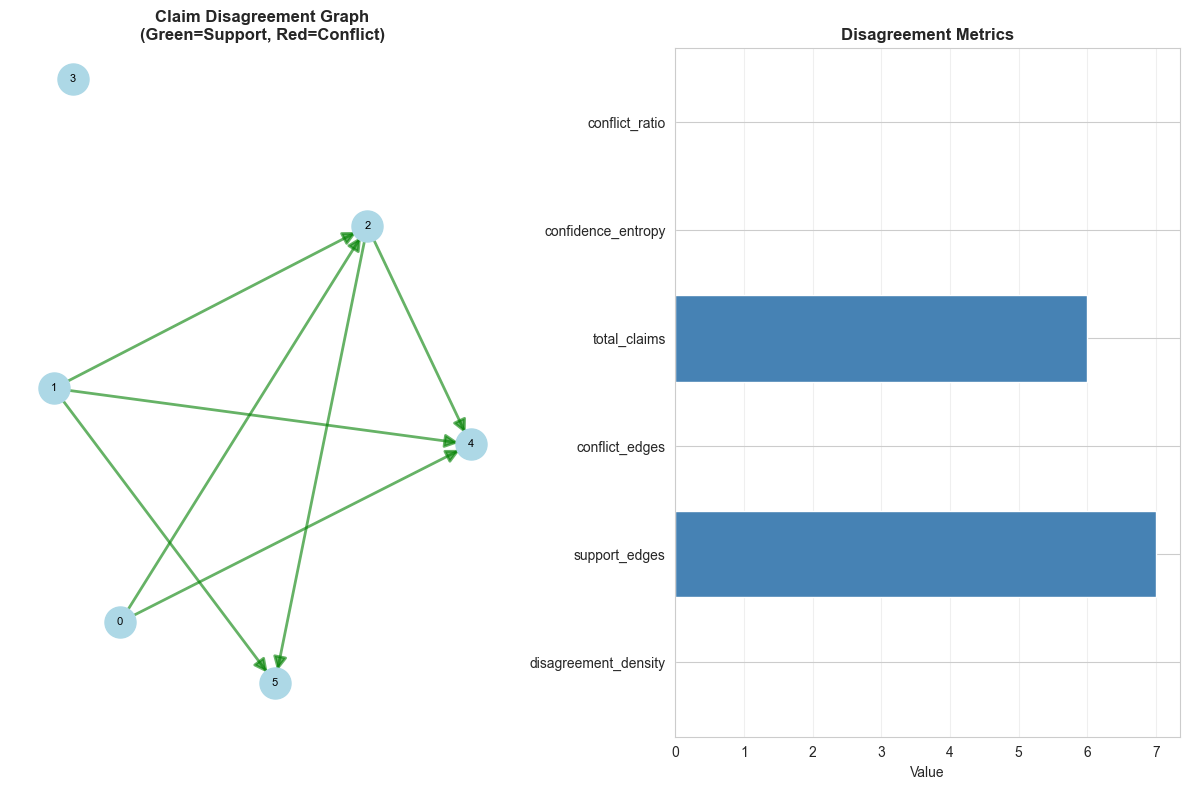


Step 6: Synthesizing multi-view answer with reasoning model...
  Generating synthesis...


2025-12-22 05:09:15,809 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"




Results:

Dominant View (high confidence):
   Cancer grade represents how fast cancer cells are likely to grow and spread within the body. A lower-grade cancer indicates slower growth while higher-grade cancers tend to be faster growing; however, it' extrinsic factors should also be considered for an accurate assessment as they affect cell beha

 Uncertainty Note:
   0% disagreement in sources

 Comprehensive Synthesis:
   Cancer grade represents how fast cancer cells are likely to grow and spread within the body. A lower-grade cancer indicates slower growth while higher-grade cancers tend to be faster growing; however, it' extrinsic factors should also be considered for an accurate assessment as they affect cell behavior beyond morphological features alone (evidence not found in provided documents).

The stage of a tumor is determined by its size and how far it has spread from the original site. A higher-stage cancer indicates that the tumor is larger or more advanced, having potent

{'query': 'What is cancer grade?',
 'retrieved_chunks': 3,
 'total_claims': 6,
 'metrics': {'disagreement_density': 0.0,
  'support_edges': 7,
  'conflict_edges': 0,
  'total_claims': 6,
  'confidence_entropy': 0.0,
  'conflict_ratio': 0.0},
 'answer': {'dominant_view': "Cancer grade represents how fast cancer cells are likely to grow and spread within the body. A lower-grade cancer indicates slower growth while higher-grade cancers tend to be faster growing; however, it' extrinsic factors should also be considered for an accurate assessment as they affect cell beha",
  'alternative_views': [],
  'confidence': 'high',
  'uncertainty_note': '0% disagreement in sources',
  'synthesis': "Cancer grade represents how fast cancer cells are likely to grow and spread within the body. A lower-grade cancer indicates slower growth while higher-grade cancers tend to be faster growing; however, it' extrinsic factors should also be considered for an accurate assessment as they affect cell behavior b

In [15]:
pipeline.query('What is cancer grade?', max_chunks=3)



Query: Are all cancers curable?


Step 1: Retrieving relevant documents...
Processing top 3 chunks (limited for speed)

Step 2: Extracting atomic claims...
  Processing chunk 1/3... 

2025-12-22 04:46:50,142 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


  Retry 1/2...


2025-12-22 04:46:53,191 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


1 claims
  Processing chunk 2/3... 

2025-12-22 04:46:56,963 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


  Retry 1/2...


2025-12-22 04:46:59,712 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


2 claims
  Processing chunk 3/3... 

2025-12-22 04:47:04,165 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"


2 claims
Total claims extracted: 5

Step 3: Analyzing claim relationships...
  Analyzing up to 10 claim pairs...


2025-12-22 04:47:08,527 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:11,752 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:13,826 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:15,888 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:17,917 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:20,514 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:22,226 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:24,986 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:26,885 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"
2025-12-22 04:47:28,935 - INFO - HTTP Request: POST http://localhost:11434/api/cha

Analyzed 10 relationships

Step 4: Computing disagreement metrics...
  disagreement_density: 0.1500
  support_edges: 6.0000
  conflict_edges: 3.0000
  total_claims: 5.0000
  confidence_entropy: 0.9183
  conflict_ratio: 0.3333

Step 5: Visualizing disagreement graph...


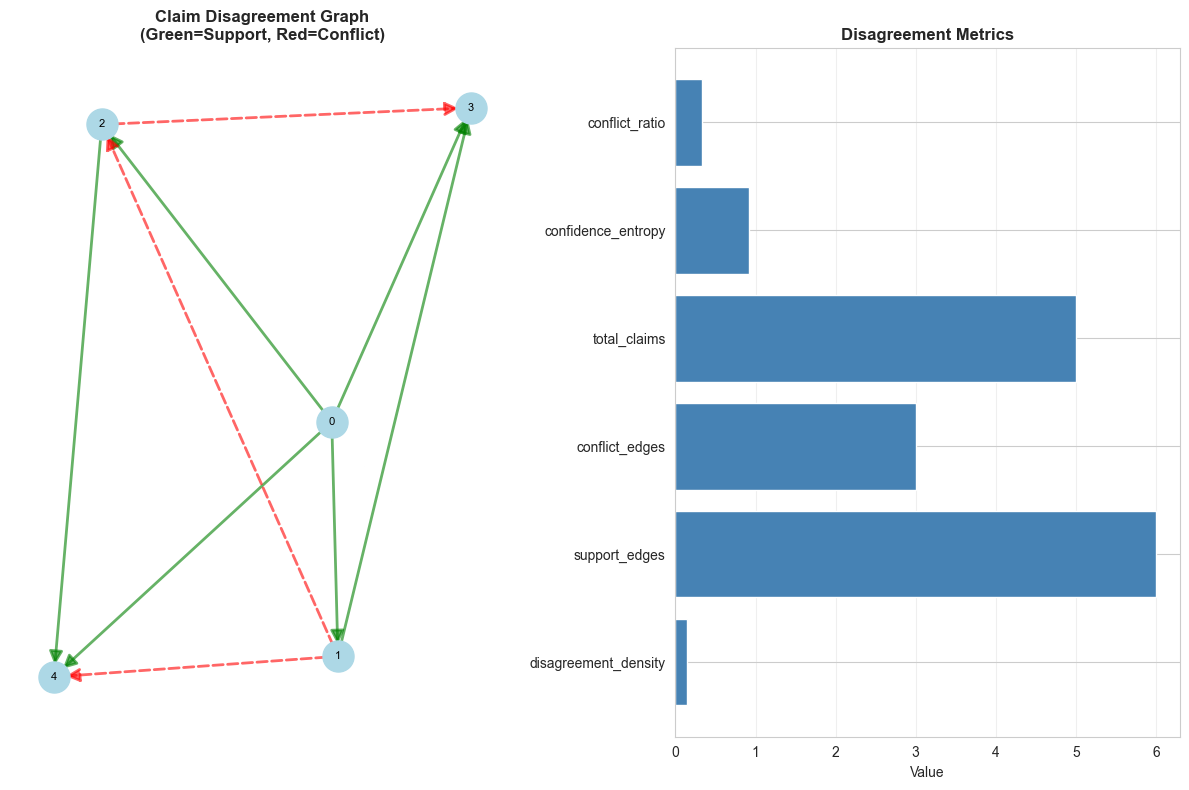


Step 6: Synthesizing multi-view answer with reasoning model...
  Generating synthesis...


2025-12-22 04:48:29,707 - INFO - HTTP Request: POST http://localhost:11434/api/chat "HTTP/1.1 200 OK"




Results:

Dominant View (low confidence):
   No, not all cancers are curable. While some types like melanoma and childhood cancers have high survival rates when diagnosed early, there is still no guarantee of a cure for any type of cancer due to the complexity of each individual case and factors such as genetic mutations that make them unrespo

 Uncertainty Note:
   33% disagreement in sources

 Comprehensive Synthesis:
   No, not all cancers are curable. While some types like melanoma and childhood cancers have high survival rates when diagnosed early, there is still no guarantee of a cure for any type of cancer due to the complexity of each individual case and factors such as genetic mutations that make them unresponsive to therapy over time.


{'query': 'Are all cancers curable?',
 'retrieved_chunks': 3,
 'total_claims': 5,
 'metrics': {'disagreement_density': 0.15,
  'support_edges': 6,
  'conflict_edges': 3,
  'total_claims': 5,
  'confidence_entropy': 0.9182958340544896,
  'conflict_ratio': 0.3333333333333333},
 'answer': {'dominant_view': 'No, not all cancers are curable. While some types like melanoma and childhood cancers have high survival rates when diagnosed early, there is still no guarantee of a cure for any type of cancer due to the complexity of each individual case and factors such as genetic mutations that make them unrespo',
  'alternative_views': [],
  'confidence': 'low',
  'uncertainty_note': '33% disagreement in sources',
  'synthesis': 'No, not all cancers are curable. While some types like melanoma and childhood cancers have high survival rates when diagnosed early, there is still no guarantee of a cure for any type of cancer due to the complexity of each individual case and factors such as genetic muta

In [12]:
pipeline.query("Are all cancers curable?", max_chunks=3)